# 📌 Dataset
In this project, we use the Walmart Sales Forecast dataset from Kaggle: https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast

The purpose of this project is creating EDA functions to use other projects

In [1]:
import kagglehub
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")
print("Path to dataset files:", path)

100%|██████████| 3.36M/3.36M [00:00<00:00, 103MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1


In [22]:
import pandas as pd
import os
import glob
from typing import Iterable, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
dfs = {}
csv_files = glob.glob(os.path.join(path, "*.csv"))
for file in csv_files:
    name = os.path.splitext(os.path.basename(file))[0]  # filename without extension
    dfs[name] = pd.read_csv(file)
    print(f"Loaded {name}.csv with shape {dfs[name].shape}")

Loaded stores.csv with shape (45, 3)
Loaded train.csv with shape (421570, 5)
Loaded test.csv with shape (115064, 4)
Loaded features.csv with shape (8190, 12)


In [4]:
train_df = dfs.get("train")
test_df = dfs.get("test")
features_df = dfs.get("features")
stores_df = dfs.get("stores")

In [5]:
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [6]:
test_df

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [7]:
features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [8]:
stores_df.head(10)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


# EDA Functions

In [9]:
def create_column_stats(df):
    stats_df = pd.DataFrame(index=df.columns)
    stats_df['Data Type'] = df.dtypes
    stats_df['Unique Count'] = df.nunique()
    stats_df['Top 3 Values'] = df.apply(
        lambda col: ', '.join([f"{val}({count})" for val, count in col.value_counts().head(3).items()])
    )
    stats_df['Non-NaN Count'] = df.count()
    stats_df['Missing Values'] = df.isnull().sum()
    stats_df['Missing %'] = (df.isnull().mean() * 100).round(2)
    return stats_df.reset_index().rename(columns={'index': 'Column Name'})

In [10]:
from pandas.io.formats.style import Styler

In [11]:
def styled_stats_table(
    df: pd.DataFrame,
    numeric_only: bool = True,
    percentiles: Tuple[float, ...] = (0.05, 0.25, 0.5, 0.75, 0.95),
    cmap: str = "Blues",
    caption: str = "Feature-wise Statistics",
    bold_cols: Iterable[str] = ("mean", "50%"),
    fmt: str = "{:.2f}"
) -> Styler:

    data = df.select_dtypes(include="number") if numeric_only else df
    if data.empty:
        raise ValueError("No columns to describe. Try numeric_only=False or check your DataFrame.")
    desc = data.describe(percentiles=list(percentiles)).T
    pct_labels = [f"{int(p*100)}%" for p in percentiles]
    ordered_cols = ["count", "mean", "std", "min", *pct_labels, "max"]
    existing_cols = [c for c in ordered_cols if c in desc.columns]
    desc = desc[existing_cols]
    gradient_subset = [c for c in desc.columns if c != "count"]
    bold_subset = [c for c in bold_cols if c in desc.columns]
    styled = (
        desc.style
        .background_gradient(cmap=cmap, axis=1, subset=gradient_subset)
        .format(fmt)
        .set_properties(**{"font-weight": "bold", "border": "1px solid black"}, subset=bold_subset)
        .set_caption(caption)
        .set_table_styles([
            {
                "selector": "caption",
                "props": [
                    ("caption-side", "top"),
                    ("font-size", "20px"),
                    ("color", "#1f77b4"),
                    ("font-weight", "bold"),
                    ("text-align", "center"),
                ],
            },
            {
                "selector": "th.col_heading",
                "props": [
                    ("background-color", "white"),
                    ("color", "black"),
                    ("text-align", "center"),
                    ("font-weight", "bold"),
                ],
            },
            {
                "selector": "th.row_heading",
                "props": [
                    ("background-color", "white"),
                    ("color", "black"),
                    ("font-weight", "bold"),
                ],
            },
        ])
    )

    return styled

In [12]:
def plot_corr_matrix(
    df: pd.DataFrame,
    method: str = "pearson",
    figsize: tuple = (10, 8),
    cmap: str = "RdBu_r",
    title: str = "Correlation Matrix",
    annot: bool = True,
    threshold: float = 0.5
):
    corr = df.corr(method=method)
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        fmt=".2f",
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8, "label": "Korelasyon"},
    )
    plt.title(title, fontsize=16, fontweight="bold", pad=20, color="#333333")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

    print(f"High correlation pairs (|r| >= {threshold}):\n")
    high_corrs = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            val = corr.iloc[i, j]
            if abs(val) >= threshold:
                high_corrs.append((corr.index[i], corr.columns[j], round(val, 3)))

    if high_corrs:
        for col1, col2, val in sorted(high_corrs, key=lambda x: -abs(x[2])):
            print(f"{col1} ↔ {col2}: {val}")
    else:
        print("All corelations are below the threshold.")


In [29]:
def plot_histograms(df: pd.DataFrame, bins: int = 30):
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) == 0:
        print("There are no numerical columns.")
        return
    n_cols = 3
    n_rows = math.ceil(len(numeric_cols) / n_cols)
    palette = sns.color_palette("Set2", len(numeric_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col].dropna(), bins=bins, kde=False, ax=axes[i], color=palette[i])
        axes[i].set_title(f"Histogram - {col}")
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [35]:
def plot_violins(df: pd.DataFrame):
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) == 0:
        print("There are no numerical columns.")
        return
    n_cols = 3
    n_rows = math.ceil(len(numeric_cols) / n_cols)
    palette = sns.color_palette("Set2", len(numeric_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(numeric_cols):
        sns.violinplot(y=df[col], ax=axes[i], color=palette[i], inner="box")
        axes[i].set_title(f"Violin - {col}")
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [37]:
def plot_boxplots(df: pd.DataFrame):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) == 0:
        print("There aren’t any numerical columns.")
        return
    n_cols = 3
    n_rows = math.ceil(len(numeric_cols) / n_cols)

    palette = sns.color_palette("Set2", len(numeric_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i], color=palette[i])
        axes[i].set_title(f"Boxplot - {col}")
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

In [49]:
def plot_timeseries(df: pd.DataFrame,
                    time_col: str,
                    feature_col: str,
                    filter_col: str,
                    filter_target,
                    color: str = "C0"):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    filtered = df[df[filter_col] == filter_target]

    if filtered.empty:
        print(f"⚠️ Filter sonucunda veri bulunamadı: {filter_col}={filter_target}")
        return

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=time_col, y=feature_col, data=filtered,
                 marker="o", linewidth=2, alpha=0.9, color=color)

    plt.title(f"{filter_col}={filter_target} için {feature_col} Time Series", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel(feature_col)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

# Train DF EDA

In [13]:
create_column_stats(train_df)

,Column Name,Data Type,Unique Count,Top 3 Values,Non-NaN Count,Missing Values,Missing %
0,Store,int64,45,"13(10474), 10(10315), 4(10272)",421570,0,0.0
1,Dept,int64,81,"1(6435), 2(6435), 3(6435)",421570,0,0.0
2,Date,object,143,"2011-12-23(3027), 2011-11-25(3021), 2011-12-16...",421570,0,0.0
3,Weekly_Sales,float64,359464,"10.0(353), 5.0(289), 20.0(232)",421570,0,0.0
4,IsHoliday,bool,2,"False(391909), True(29661)",421570,0,0.0


In [14]:
styled_stats_table(train_df)

,count,mean,std,min,5%,25%,50%,75%,95%,max
Store,421570.00,22.20,12.79,1.00,3.00,11.00,22.00,33.00,43.00,45.00
Dept,421570.00,44.26,30.49,1.00,4.00,18.00,37.00,74.00,95.00,99.00
Weekly_Sales,421570.00,15981.26,22711.18,-4988.94,59.97,2079.65,7612.03,20205.85,61201.95,693099.36


In [15]:
create_column_stats(train_df)

,Column Name,Data Type,Unique Count,Top 3 Values,Non-NaN Count,Missing Values,Missing %
0,Store,int64,45,"13(10474), 10(10315), 4(10272)",421570,0,0.0
1,Dept,int64,81,"1(6435), 2(6435), 3(6435)",421570,0,0.0
2,Date,object,143,"2011-12-23(3027), 2011-11-25(3021), 2011-12-16...",421570,0,0.0
3,Weekly_Sales,float64,359464,"10.0(353), 5.0(289), 20.0(232)",421570,0,0.0
4,IsHoliday,bool,2,"False(391909), True(29661)",421570,0,0.0


# Test DF EDA

# features_df EDA

In [16]:
create_column_stats(features_df)

,Column Name,Data Type,Unique Count,Top 3 Values,Non-NaN Count,Missing Values,Missing %
0,Store,int64,45,"1(182), 2(182), 3(182)",8190,0,0.00
1,Date,object,182,"2010-02-05(45), 2010-02-12(45), 2010-02-19(45)",8190,0,0.00
2,Temperature,float64,4178,"50.43(11), 70.28(11), 67.87(10)",8190,0,0.00
3,Fuel_Price,float64,1011,"3.638(43), 3.417(43), 3.63(40)",8190,0,0.00
4,MarkDown1,float64,4023,"17.01(2), 460.73(2), 2920.43(2)",4032,4158,50.77
5,MarkDown2,float64,2715,"3.0(11), 1.5(10), 0.5(9)",2921,5269,64.33
6,MarkDown3,float64,2885,"1.0(17), 2.0(15), 3.0(15)",3613,4577,55.89
7,MarkDown4,float64,3405,"3.0(5), 2.0(4), 2.61(4)",3464,4726,57.70
8,MarkDown5,float64,4045,"1327.97(2), 2743.18(2), 3113.78(2)",4050,4140,50.55
9,CPI,float64,2505,"132.7160968(33), 139.1226129(24), 224.8025314(12)",7605,585,7.14


In [17]:
features_df["Date"] = pd.to_datetime(features_df["Date"], format="%Y-%m-%d", errors="coerce")

In [18]:
styled_stats_table(features_df)

,count,mean,std,min,5%,25%,50%,75%,95%,max
Store,8190.00,23.00,12.99,1.00,3.00,12.00,23.00,34.00,43.00,45.00
Temperature,8190.00,59.36,18.68,-7.29,26.85,45.90,60.71,73.88,87.13,101.95
Fuel_Price,8190.00,3.41,0.43,2.47,2.67,3.04,3.51,3.74,4.02,4.47
MarkDown1,4032.00,7032.37,9262.75,-2781.45,109.42,1577.53,4743.58,8923.31,21500.93,103184.98
MarkDown2,2921.00,3384.18,8793.58,-265.76,2.98,68.88,364.57,2153.35,17261.44,104519.54
MarkDown3,3613.00,1760.10,11276.46,-179.26,0.78,6.60,36.26,163.15,1159.76,149483.31
MarkDown4,3464.00,3292.94,6792.33,0.22,18.47,304.69,1176.42,3310.01,12863.77,67474.85
MarkDown5,4050.00,4132.22,13086.69,-185.17,577.68,1440.83,2727.14,4832.56,10227.86,771448.10
CPI,7605.00,172.46,39.74,126.06,126.56,132.36,182.76,213.93,223.87,228.98
Unemployment,7605.00,7.83,1.88,3.68,5.14,6.63,7.81,8.57,10.93,14.31


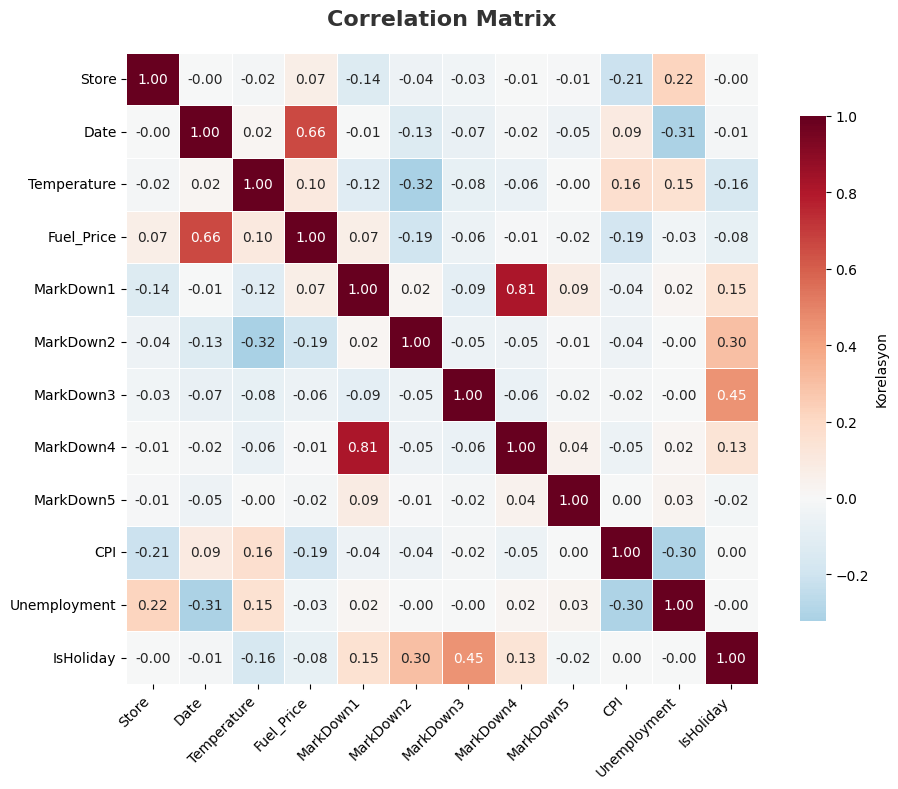

High correlation pairs (|r| >= 0.5):

MarkDown1 ↔ MarkDown4: 0.81
Date ↔ Fuel_Price: 0.663


In [19]:
plot_corr_matrix(features_df)

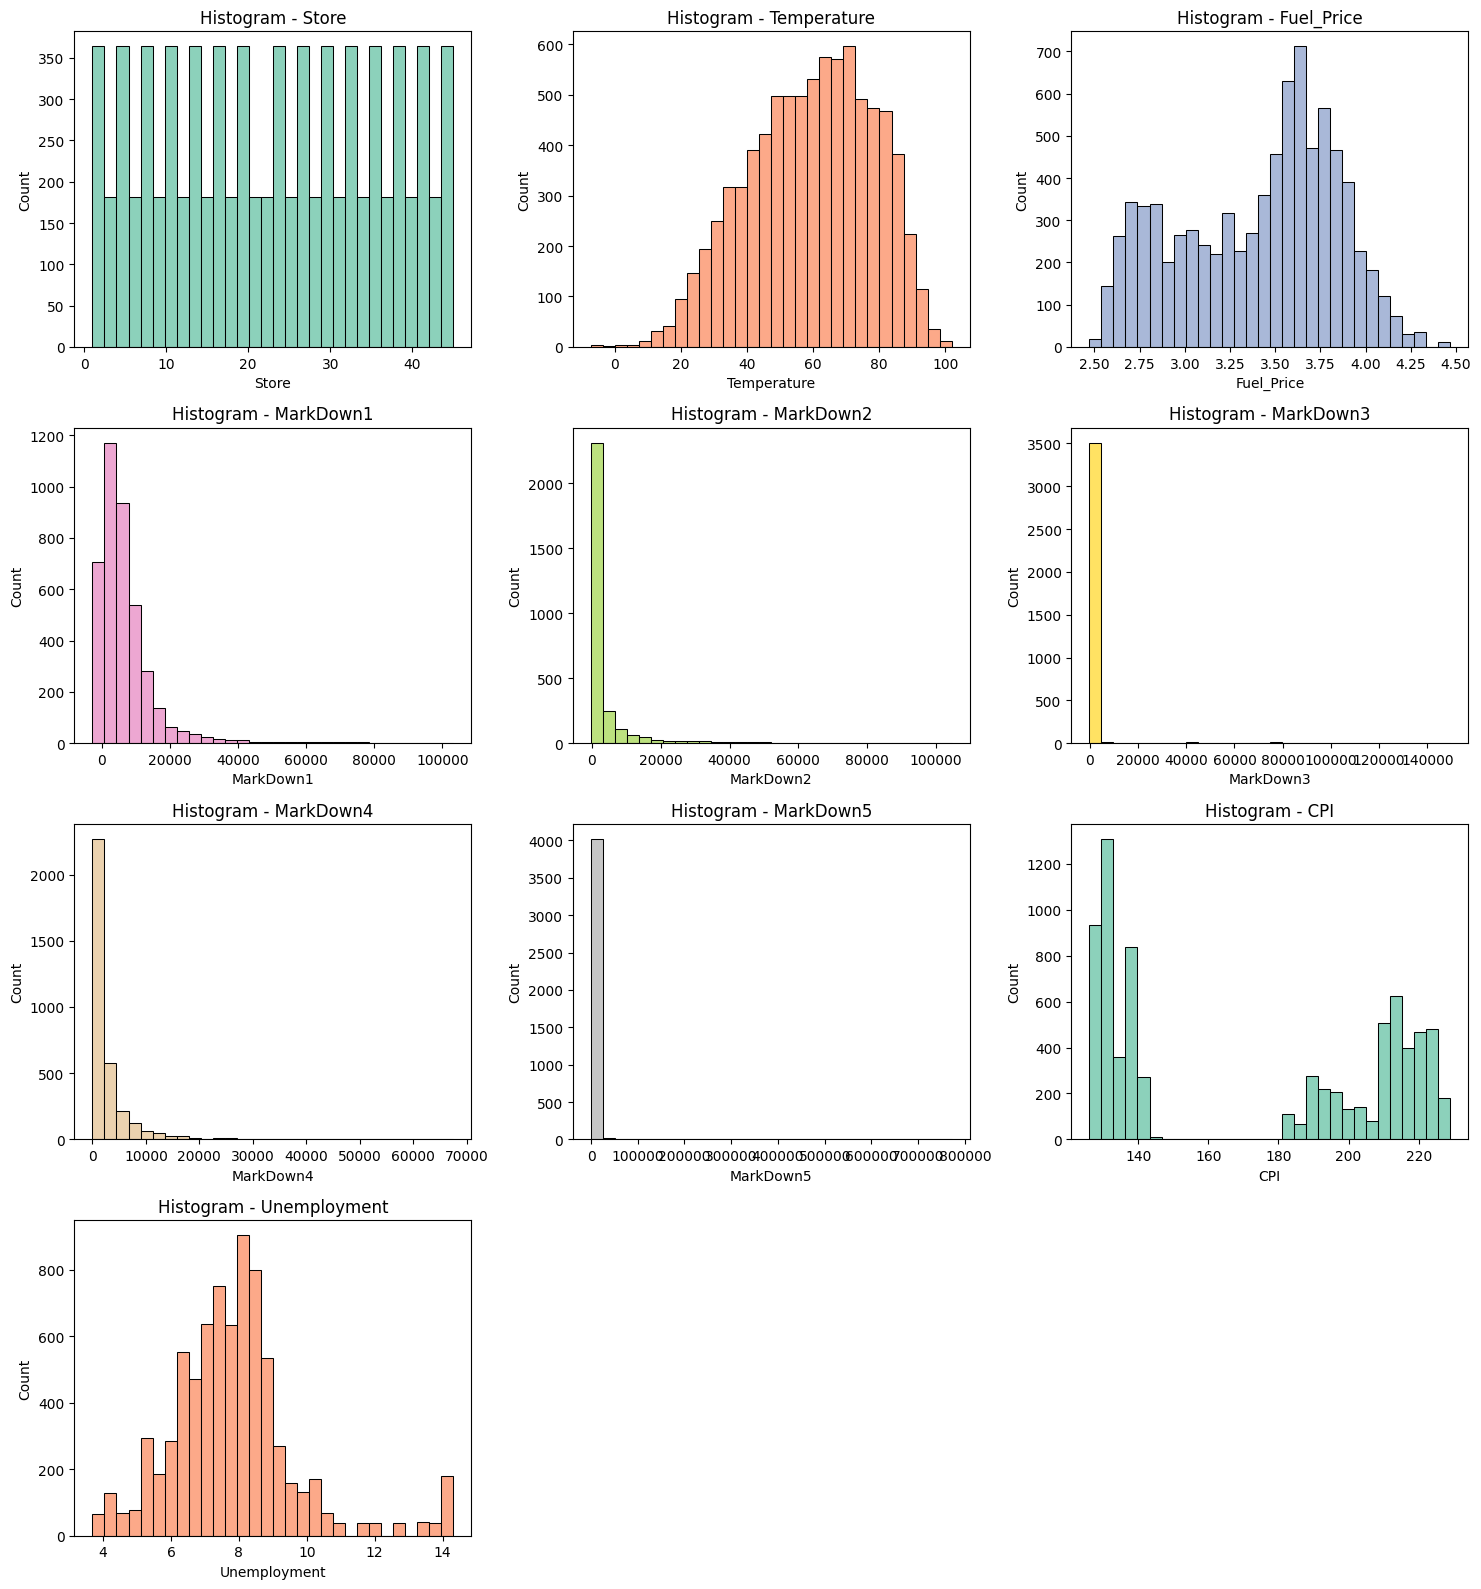

In [30]:
plot_histograms(features_df)

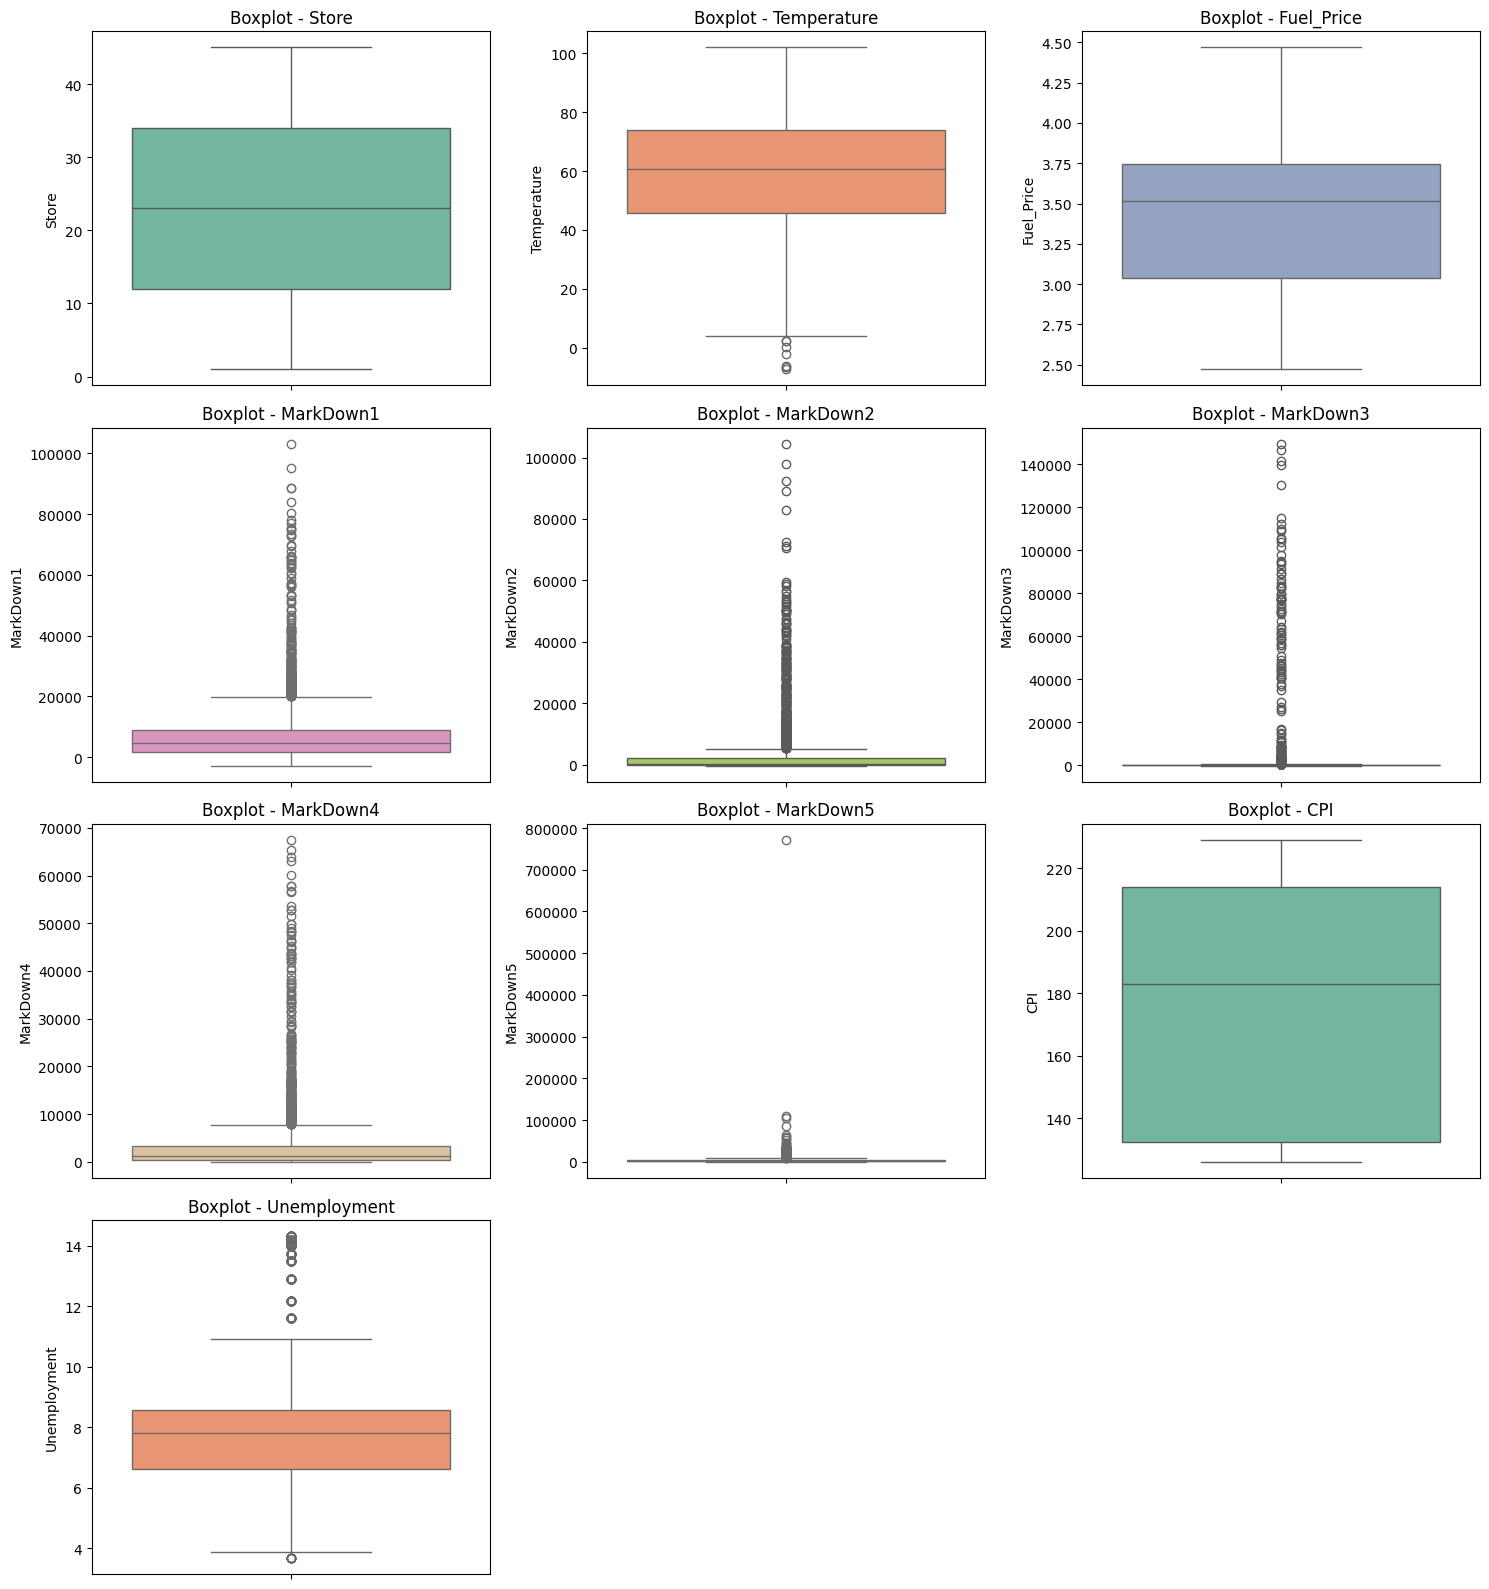

In [28]:
plot_boxplots(features_df)

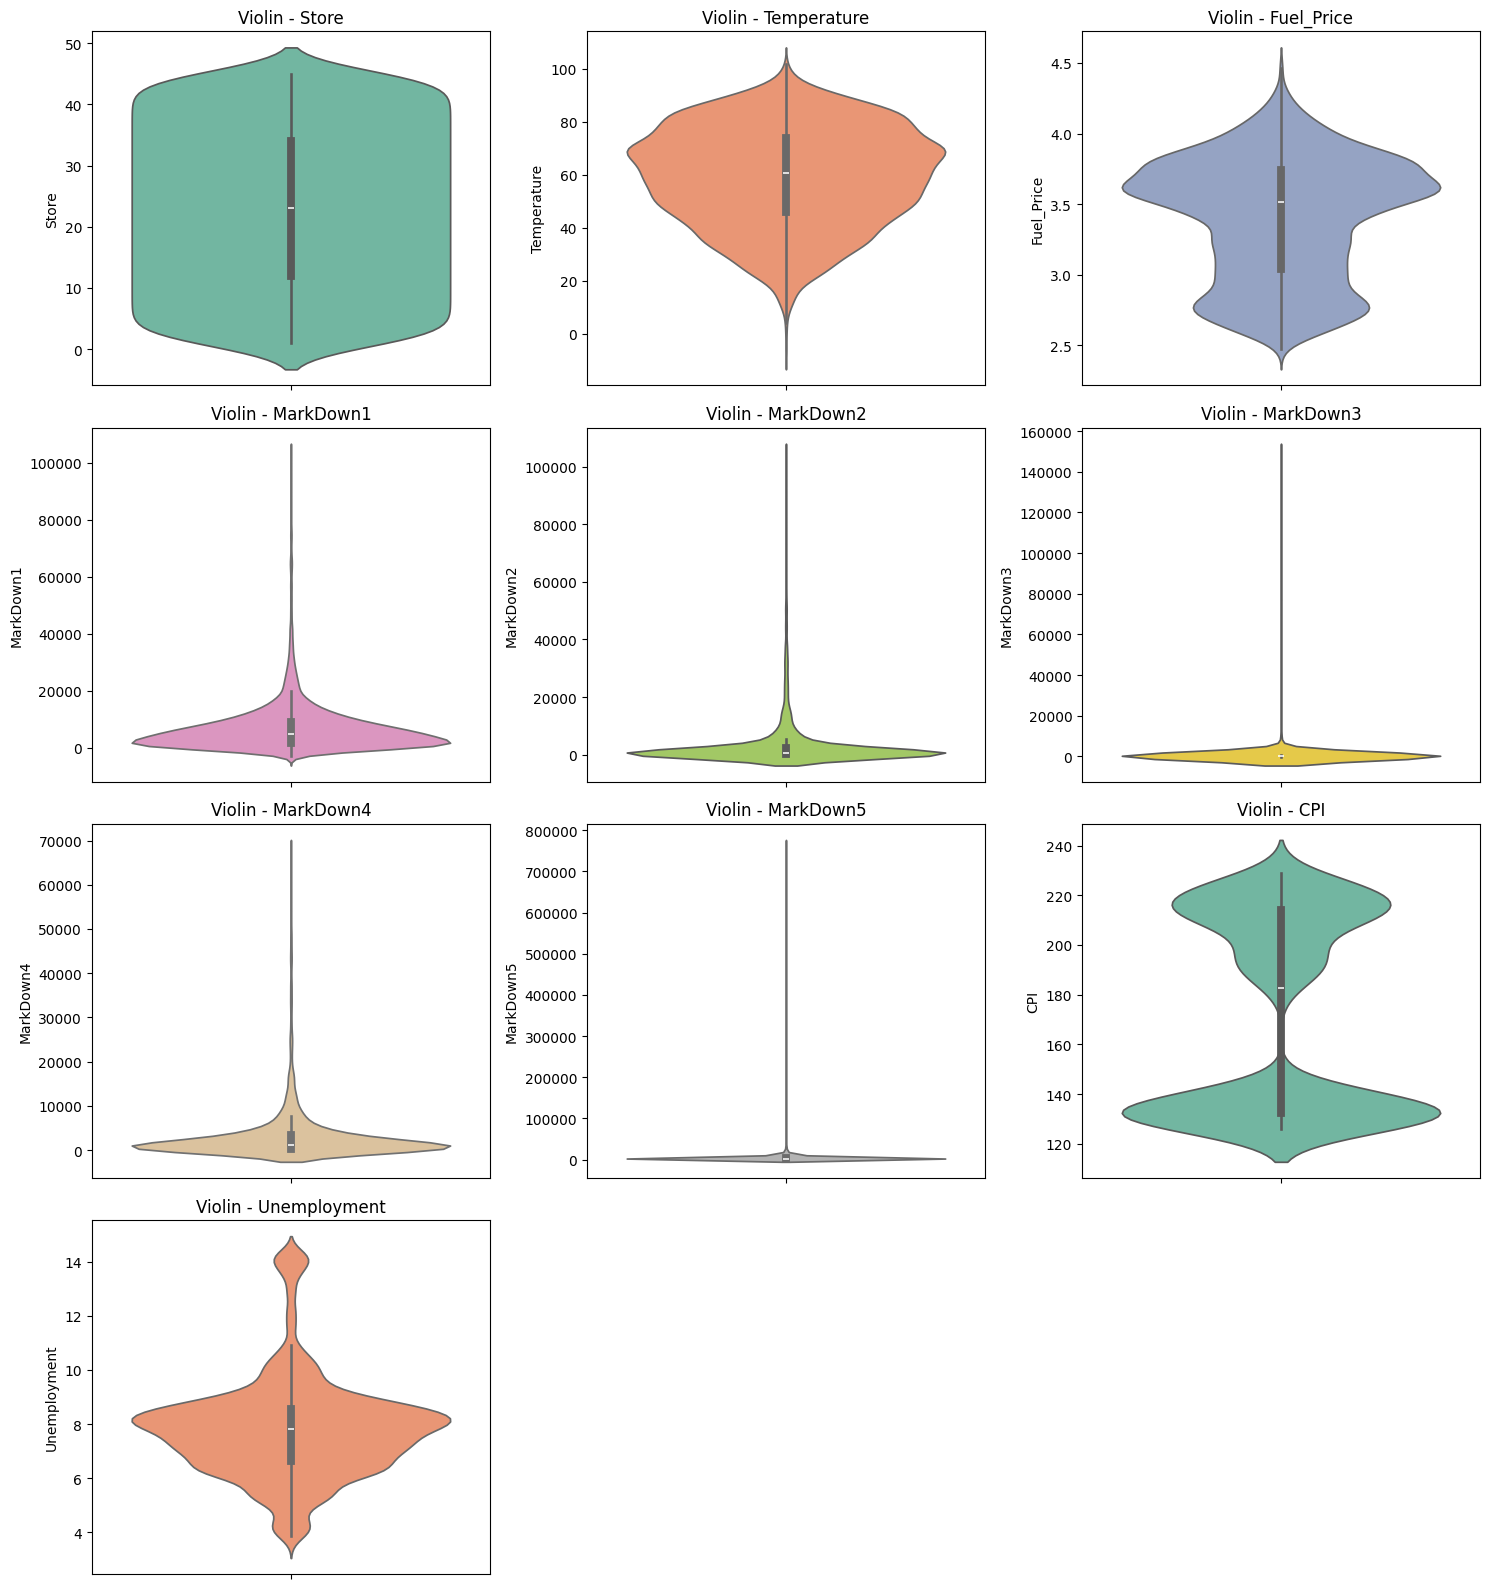

In [36]:
plot_violins(features_df)

In [40]:
features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


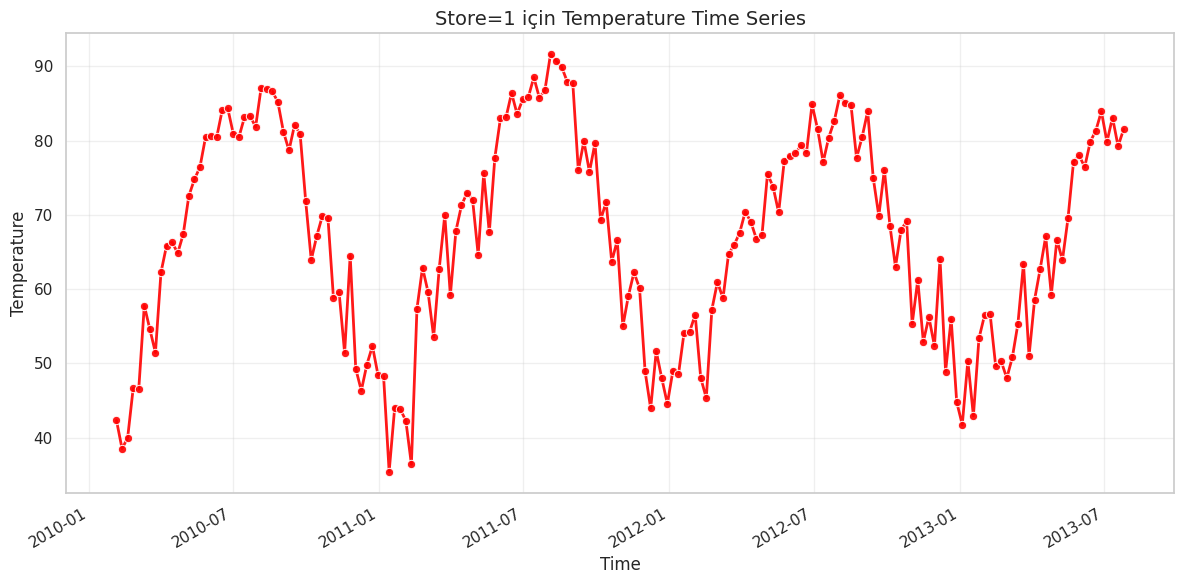

In [51]:
plot_timeseries(features_df, time_col="Date", feature_col="Temperature",
                filter_col="Store", filter_target=1, color="red")

# Stores EDA
